# 0. Import packages

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

# 1. Decoder summary
### Encoder

* **Input**: Takes the **source sequence** (e.g., English sentence).
* **Layers**: Stack of self-attention + feed-forward layers.
* **Self-Attention**: **Bidirectional** — every token can attend to all others.
* **Output**: Encoded representation of the whole sequence (contextual embeddings).

---

### Decoder

* **Input**: Takes the **target sequence so far** (e.g., translated words already generated).
* **Layers**: Similar stack, but with **two attention modules**:
  1. **Masked self-attention** (so tokens can’t see the “future”).
  2. **Cross-attention**
     - (k, v) -> encoder
     - q -> decoder input
* **Self-Attention**: **Unidirectional (causal)**.
* **Output**: Next token prediction step by step.

---

**In short**:

* **Encoder** = reads and understands the input.
* **Decoder** = generates output, one token at a time, while attending to both past outputs and the encoder’s context.

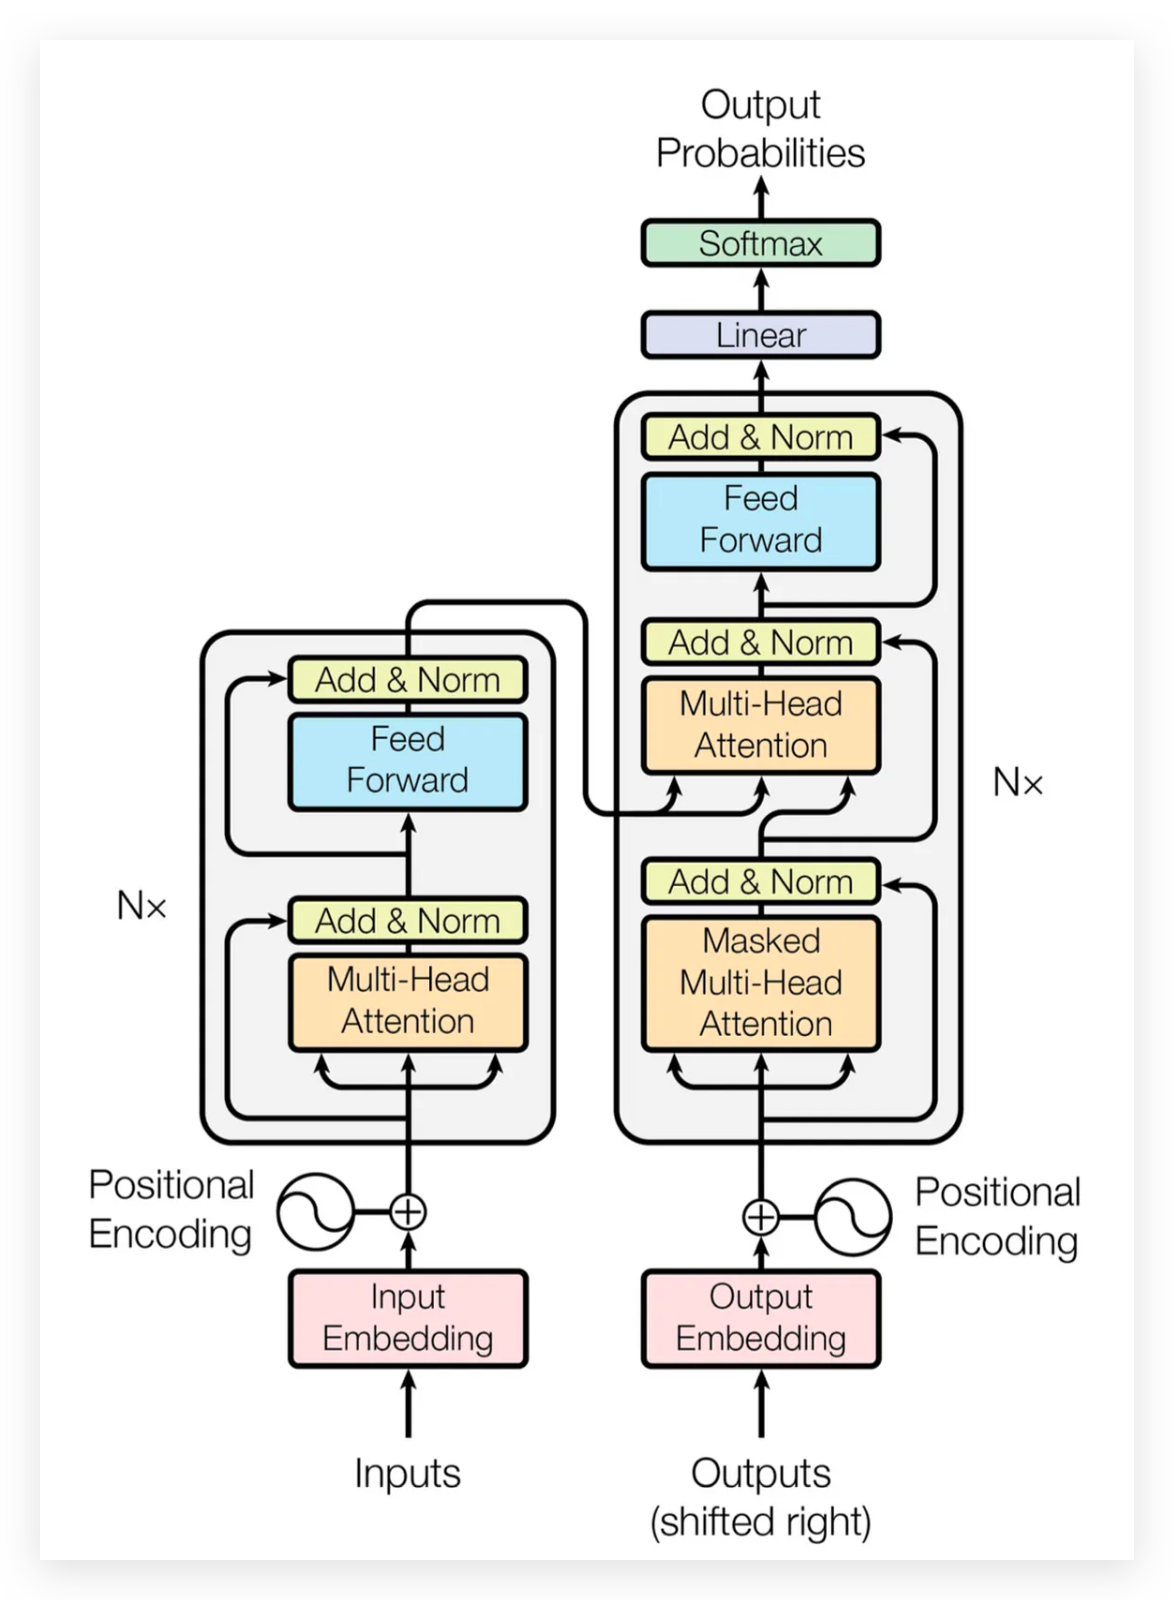

In [2]:
Image(filename='Images/transformer.png', width=500)

# 2. mask

In [3]:
model_name = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

text = 'Lift is a struggle'
token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
model_input = tokenizer(text, return_tensors='pt', add_special_tokens=False)
input_embeddings = token_embedding(model_input['input_ids'])

### 2.1 Lower triangular matrix

In [4]:
import math

q = k = v = input_embeddings
attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(k.size(-1)) # 1 * seq_len * seq_len

# Create a tril matrix
seq_len = input_embeddings.size(1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0) # 1 * seq_len * seq_len

attn_scores.masked_fill_(mask == 0, -float('inf'))

tensor([[[29.0343,    -inf,    -inf,    -inf],
         [-0.3627, 29.0490,    -inf,    -inf],
         [-1.8660, -0.9291, 27.8502,    -inf],
         [ 0.4249, -0.5930, -1.1651, 25.5088]]], grad_fn=<MaskedFillBackward0>)

# 3. Masked self attention

In [7]:
def scaled_dot_product_attention(q, k, v, mask=None):
    attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(k.size(-1))
    if mask is not None:
        attn_scores.masked_fill_(mask == 0, -float('inf'))
    attn_weights = torch.softmax(attn_scores, dim=-1)
    return torch.matmul(attn_weights, v)

scaled_dot_product_attention(q, k, v, mask)

tensor([[[ 0.1171, -0.8469,  0.0364,  ..., -0.6883,  1.4534, -1.3840],
         [-1.9328, -1.2848, -0.7241,  ..., -0.9789, -0.0403,  0.6008],
         [ 0.1399, -0.4541, -0.8839,  ..., -1.7310, -1.0048,  1.0810],
         [ 0.4417,  1.8732, -0.5404,  ...,  0.4583, -0.2639, -0.1517]]],
       grad_fn=<UnsafeViewBackward0>)

# 4. Implement decoder in hand
Decoder layer:
- hidden_states: 512
- num of heads: 8

The meaning of vector: (len_sequence, batch_size, hidden_states)

In [19]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)

memory = torch.rand(10, 32, 512) # encoder output
target = torch.rand(20, 32, 512) # decoder input

In [20]:
decoder_layer.eval()
out = decoder_layer(target, memory)
out.shape, out[0][0][0: 64], decoder_layer.eval()

(torch.Size([20, 32, 512]),
 tensor([ 1.0403,  0.5499, -0.6031, -0.9999, -1.5875,  1.5258,  1.1269, -1.1724,
         -0.1312,  1.4835,  0.1128, -0.7938,  0.1837, -0.1883,  0.6957,  0.7017,
         -1.0062,  1.0198, -0.9646,  0.3633,  0.5202,  0.2697, -1.0204,  1.4943,
          0.0748,  0.4569,  1.5159, -0.4840, -0.8130,  1.1831,  0.5046,  0.2046,
          0.4835,  0.3507,  0.1817,  0.9635, -0.7838, -0.3674, -1.2319,  1.5211,
         -1.3750,  0.0712,  0.4534,  0.3601,  0.5966, -0.8610,  1.4639, -0.5052,
          2.0517,  0.4495, -1.1532, -0.0777,  0.0928,  1.1589, -0.6962,  1.0951,
         -0.3840,  0.6213, -0.6068, -0.3299, -1.1829, -0.1479,  0.7357,  0.7376],
        grad_fn=<SliceBackward0>),
 TransformerDecoderLayer(
   (self_attn): MultiheadAttention(
     (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
   )
   (multihead_attn): MultiheadAttention(
     (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, b

In PyTorch's nn.MultiheadAttention or HuggingFace's attention, a tuple is usually returned when called.
- Element 0 (output) → Hidden states after the attention layer (main result).
- Element 1 (attn_weights) → Attention weight matrix (can be used for visualization or analysis).

In [23]:
# multi head -> masked multihead self attention
def self_attention(x):
    x = decoder_layer.self_attn(x, x, x)[0]
    x = decoder_layer.dropout1(x)
    return x

# multi head -> multihead attention
def cross_attention(q, k, v=None):
    if v is None:
        v = k
    x = decoder_layer.multihead_attn(q, k, v)[0]
    x = decoder_layer.dropout2(x)
    return x

def ffn(x):
    x = decoder_layer.dropout(F.relu(decoder_layer.linear1(x)))
    x = decoder_layer.linear2(x)
    return x

## 4.1 Build decoder
- Post LayerNorm
    - self_attention(self_attention -> dropout1) -> norm1 -> residual ->
    - cross_attention(multihead_attn -> dropout2) -> norm2 -> residual ->
    - ffn(linear1 -> relu -> dropout -> linear2) -> nrom3 -> residual
- Pre LayerNorm
    - norm1 -> self_attention(self_attention -> dropout1) -> residual ->
    - norm2 -> cross_attention(multihead_attn -> dropout2) -> residual ->
    - nrom3 -> ffn(linear1 -> relu -> dropout -> linear2) -> residual

In [24]:
def decoder_forward(target, memory, pre_norm=False):
    x = target
    if pre_norm:
        x = x + self_attention(decoder_layer.norm1(x))
        x = x + cross_attention(deocder_layer.norm2(x), memory)
        x = x + ffn(decoder_layer.norm3(x))
    else:
        x = decoder_layer.norm1(x + self_attention(x))
        x = decoder_layer.norm2(x + cross_attention(x, memory))
        x = decoder_layer.norm3(x + ffn(x))
    return x

In [26]:
decoder_forward(target, memory)[0][0][0: 64]

tensor([ 1.0403,  0.5499, -0.6031, -0.9999, -1.5875,  1.5258,  1.1269, -1.1724,
        -0.1312,  1.4835,  0.1128, -0.7938,  0.1837, -0.1883,  0.6957,  0.7017,
        -1.0062,  1.0198, -0.9646,  0.3633,  0.5202,  0.2697, -1.0204,  1.4943,
         0.0748,  0.4569,  1.5159, -0.4840, -0.8130,  1.1831,  0.5046,  0.2046,
         0.4835,  0.3507,  0.1817,  0.9635, -0.7838, -0.3674, -1.2319,  1.5211,
        -1.3750,  0.0712,  0.4534,  0.3601,  0.5966, -0.8610,  1.4639, -0.5052,
         2.0517,  0.4495, -1.1532, -0.0777,  0.0928,  1.1589, -0.6962,  1.0951,
        -0.3840,  0.6213, -0.6068, -0.3299, -1.1829, -0.1479,  0.7357,  0.7376],
       grad_fn=<SliceBackward0>)